---
### Universidad de Costa Rica
#### IE0405 - Modelos Probabilísticos de Señales y Sistemas
---

- Estudiante: **Yennifer Espinoza Fuentes y Sofia Villalobos Brenes**
- Carné: **B82754 y B98464**
- Grupo: **1**


# `P5` - *Procesos M/M/s*

> El caso especial de los procesos aleatorios donde existen "estados" y "transiciones" entre estos estados, las cadenas de Markov modelan las probabilidades de transición y el tiempo de permanencia entre cada estado. En particular, la teoría de colas describe la evolución del número de elementos en la fila, dado un flujo de entrada y un flujo de salida.

---

---

## Parte 1


#### Del enunciado:

- $\lambda = 4$ personas por minuto.
- $\nu = 0.25$ personas por minuto.
- No exceder las 50 personas en fila durante el 95% del tiempo de servicio, es por eso que $i = 50$.

#### Determinación teórica de la cantidad de servidores $s$:

Se observa que se trata de un proceso $\textbf{M/M/s}$ donde es un sistema que no exceda las 50 personas durante el 95% del tiempo, entonces:

$$
P( \text{51 o más clientes en el sistema} ) = \sum_{i=51}^{\infty} (1 - \rho) \rho^i  = 1 - \sum_{i=0}^{50} (1 - \rho) \rho^i = \rho^{50}
$$

Entonces como $\rho^{50} = \big(\frac{\lambda}{s\nu}\big)^{50}$ y sabemos que se requiere una probabilidad menor o igual al 5%=0.05 (recordando que el 95% del tiempo no se debe exceder el límite de 50 personas):

$$
P( \text{51 o más clientes en el sistema} ) = \rho^{50} = \left(\frac{\lambda}{s\nu}\right)^{50}
$$

Y por lo mencionando entonces $ \rho^{50} \leq 0.05 $:
$$
\frac{\lambda^{50}}{s^{50}\nu^{50}} \leq 0.05
$$

Y como $\lambda$ como $\nu$ son valores conocidos, se puede despejar la cantidad de servidores $s$ tal que:

$$
s^{50} \geq \frac{\lambda^{50}}{0.05\cdot\nu^{50}}
$$
$$
s \geq \left(\frac{\lambda^{50}}{0.05\cdot\nu^{50}}\right)^{\frac{1}{50}} 
$$

$$
s \geq \frac{4}{(0.05)^{\frac{1}{50}}0.25} 
$$

$$
s \geq 16.9879 \approx 17
$$


Se requieren al menos 17 servidores para cumplir los requisitos.

---

## Parte 2

Se modifica el código dado en el enunciado para dichos requerimientos y se realizan 2 gráficos para comprobar lo obtenido

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt


def simulacion(s):

    ''' Parámetro de la función simulacion:
    - s: Número de servidores '''

    N = 1000  # Número de clientes
    lam = 4/60  # Tasa de llegada en personas/segundo
    nu = 0.25/60  # Tasa de partida en personas/segundo

    # Distribución de los tiempos de llegada entre cada cliente
    X = stats.expon(scale=1/lam)

    # Distribución de los tiempos de servicio a cada cliente
    Y = stats.expon(scale=1/nu)

    # Intervalos entre llegadas (segundos desde último cliente)
    t_intervalos = np.ceil(X.rvs(N)).astype('int')

    # Tiempos de las llegadas (segundos desde el inicio)
    t_llegadas = [t_intervalos[0]]
    for i in range(1, len(t_intervalos)):
        siguiente = t_llegadas[i-1] + t_intervalos[i]
        t_llegadas.append(siguiente)

    # Tiempos de servicio (segundos desde inicio de servicio)
    t_servicio = np.ceil(Y.rvs(N)).astype('int')

    # Vector con los tiempos de fin de servicio de servidores
    servidores = np.zeros(s)

    # Inicialización del tiempo de inicio y fin de atención
    inicio = t_llegadas[0]          # primera llegada
    fin = inicio + t_servicio[0]    # primera salida

    # Primera asignación de un servidor
    servidores[0] = fin

    # Tiempos en que recibe atención cada i-ésimo cliente (!= que llega)
    t_atencion = [inicio]

    for i in range(1, N):
        desocupados = np.where(servidores <= t_llegadas[i])[0]
        if desocupados.size == 0:  # si no hay desocupados
            inicio = np.min(servidores) + 1
            fin = inicio + t_servicio[i]
            # Asignación del servidor
            minimo = np.min(servidores)
            serv = servidores.tolist().index(minimo)
            servidores[serv] = fin
        else:  # si hay al menos uno desocupado
            inicio = t_llegadas[i]
            fin = inicio + t_servicio[i]
            # Asignación del servidor
            serv = desocupados[0]
            servidores[serv] = fin

        t_atencion.append(inicio.astype(int))

    # Inicialización del vector temporal para registrar eventos
    t = np.zeros(t_atencion[-1] + max(t_servicio) + 1)

    # Asignación de eventos de llegada (+1) y salida (-1) de clientes
    for c in range(N):
        i = t_llegadas[c]
        t[i] += 1
        j = t_atencion[c] + t_servicio[c]
        t[j] -= 1

    # Umbral de P o más personas en sistema (hay P - 1 en fila)
    P = 51

    # Instantes (segundos) de tiempo con P o más solicitudes en sistema
    exceso = 0

    # Proceso aleatorio (estados n = {0, 1, 2...})
    Xt = np.zeros(t.shape)

    # Inicialización de estado n
    n = 0

    # Recorrido del vector temporal y conteo de clientes (estado n)
    for i, c in enumerate(t):
        n += c  # sumar (+1) o restar (-1) al estado
        Xt[i] = n
        if Xt[i] >= P:
            exceso += 1

    # Fracción de tiempo con P o más solicitudes en sistema
    fraccion = exceso / len(t)

    # Resultados
    print('Parámetro lambda =', str(lam*60))
    print('Parámetro nu =', str(nu*60))
    print('Cantidad de servidores =', str(s))
    print('Tiempo con más de {} solicitudes en fila:'.format(P-1))
    print('\t {:0.2f}%'.format(100*fraccion))

    if fraccion <= 0.05:
        print('\t Sí cumple con la especificación.')
    else:
        print('\t No cumple con la especificación.')
    print('Simulación es equivalente a {:0.2f} horas.'.format(len(t)/3600))

    # Gráfica de X(t) (estados del sistema)
    plt.figure()
    plt.plot(Xt)
    plt.plot(range(len(t)), (P-1)*np.ones(t.shape))
    plt.legend(('$X(t) = n$', '$L_q = $' + str(P-1)))
    plt.ylabel('Clientes en el sistema, $n$')
    plt.xlabel('Tiempo, $t$ / segundos')
    plt.xlim((0, 15000))
    plt.show()


Parámetro lambda = 4.0
Parámetro nu = 0.25
Cantidad de servidores = 17
Tiempo con más de 50 solicitudes en fila:
	 0.00%
	 Sí cumple con la especificación.
Simulación es equivalente a 4.73 horas.


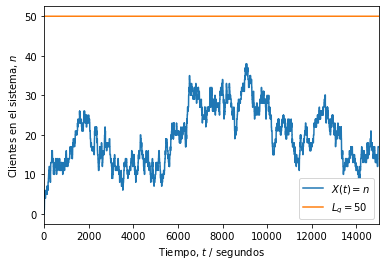

Parámetro lambda = 4.0
Parámetro nu = 0.25
Cantidad de servidores = 15
Tiempo con más de 50 solicitudes en fila:
	 5.95%
	 No cumple con la especificación.
Simulación es equivalente a 4.87 horas.


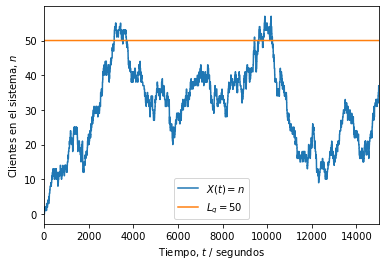

In [2]:
# Siempre va a funcionar según lo obtenido teóricamente
s1 = 17
simulacion1 = simulacion(s1)

# No funciona debido a lo obtenido teóricamente
s2 = 15
simulacion2 = simulacion(s2)


Como se puede notar cumple el requisito donde funciona con los datos dados usando 17 servidores y ya con 15 servidores no logra tener menos de __50__ solicitudes en fila por el __95%__ del tiempo. Cabe destacar que como el orden en el que llegan las personas es aleatorio, podría funcionar con menos de 17 servidores pero solo en casos específicos.

---

**Universidad de Costa Rica**

Facultad de Ingeniería

Escuela de Ingeniería Eléctrica

---